I've begun to think about how the parameters used in the PWVD may affect tracking. This is a known thing [1], but it also seems like the parameters need to be varied according to signal type. 


#### References
[1] Shin, YS, Jeon, JJ, 1993, Pseudo Wigner-Ville time-Frequency Distribution ..., Shock and Vibration Vol. 1, No. 1, pp65-76 

In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt 
from measure_horseshoe_bat_calls import data
from measure_horseshoe_bat_calls.signal_processing import dB, get_power_spectrum
import numpy as np
import scipy.signal as signal 
import soundfile as sf
import tftb
from tftb.processing import PseudoWignerVilleDistribution
from tqdm import tqdm

### Example calls: as seen in the spectrogram
Let's load some example calls into the work space:

In [3]:
all_data = data.example_calls
some_egs = all_data[:4]

<IPython.core.display.Javascript object>


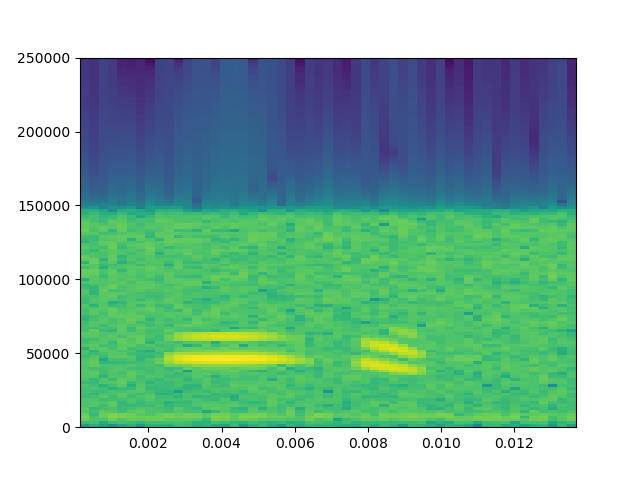

<IPython.core.display.Javascript object>


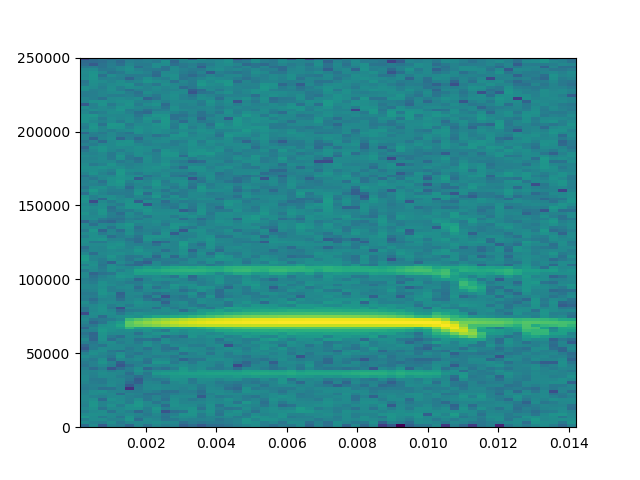

<IPython.core.display.Javascript object>


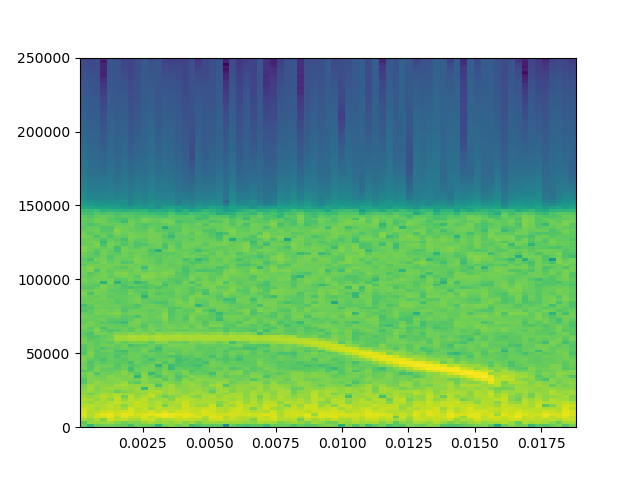

<IPython.core.display.Javascript object>


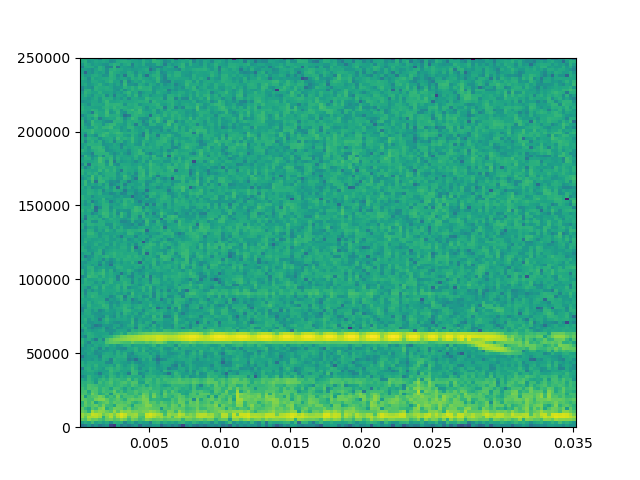

In [4]:
for each in some_egs:
    audio = each[0]
    fs = each[1]
    plt.figure()
    plt.specgram(audio, Fs=fs)

### The effect of window size on the PWVD: 
Let's look at the multiharmonic *L. aurita* calls as they are the trickiest to track. 

<IPython.core.display.Javascript object>


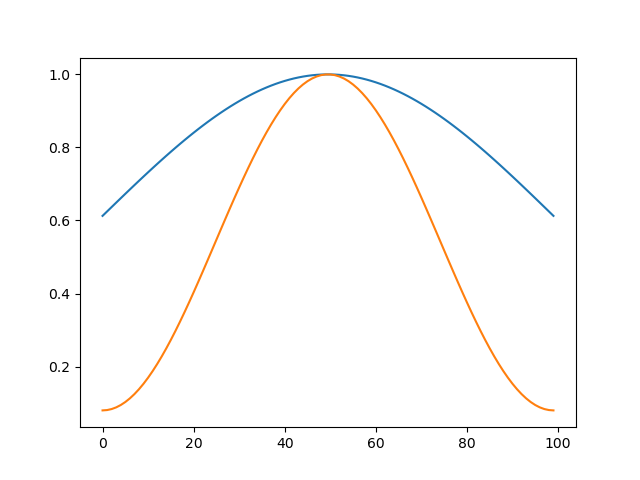

In [5]:
plt.figure()
plt.plot(signal.gaussian(100,50))
plt.plot(signal.hamming(100))

In [6]:
l_aurita = some_egs[0]
fs_la = l_aurita[1]
audio_la = l_aurita[0]
audio_la = audio_la[int(0.001*fs_la):-int(0.002*fs_la)]
window_sizes = [0.001, 0.002, 0.004]
windows = [ signal.hamming(int(l_aurita[1]*winsize)) for  winsize in window_sizes ]

In [7]:
all_pwvds = []
for each_winsize in windows:
    analytical = signal.hilbert(l_aurita[0])
    p = PseudoWignerVilleDistribution(analytical, fwindow=each_winsize);
    pwvd, t, f = p.run();
    all_pwvds.append(pwvd)


<IPython.core.display.Javascript object>


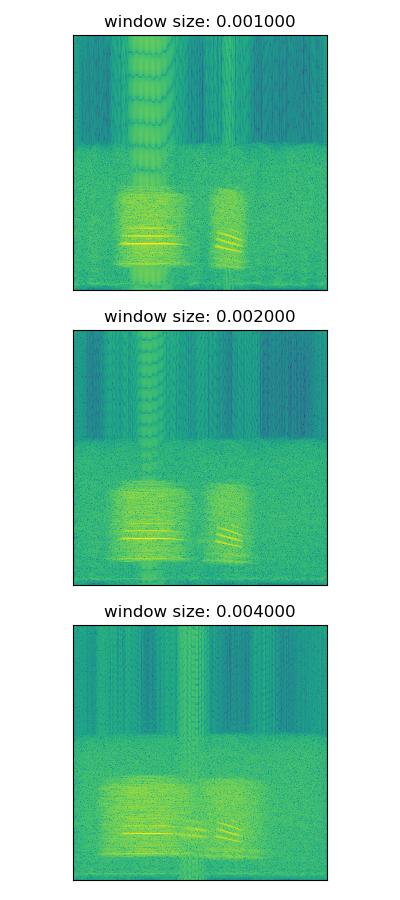

In [8]:
plt.figure(figsize=(4,9))
for i, each in enumerate(all_pwvds):
    plt.subplot(311+i)
    plt.imshow(dB(abs(all_pwvds[i])), origin='lower')
    plt.title('window size: %f'%window_sizes[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

#### As reported in the literature, the frequency resolution of the PWVD gets better with window size, but the temporal resolution also gets worse. The 4ms window shows the clear dominance of the first harmonic, but because of its length, the well-known interference terms appear between the Cf and FM components!

### The effect of window type:
The tftb python package chooses a hamming window by default. What is the effect of other window types, for instance in [1], they use a gaussian window. Here I will choose a 1ms window to purposefully choose a somewhat 'noisy' version of the PWVD, and to demonstrate the effect of the window type even better. 

In [9]:
twoms_samples = int(fs_la*0.001)
window_types = {'hamming':signal.hamming(twoms_samples),
                'hanning': signal.hann(twoms_samples),
                'gaus_lowstd':signal.gaussian(twoms_samples, 20),
               'gaus_highstd':signal.gaussian(twoms_samples, 50),
                'tukey':signal.tukey(twoms_samples, 0.5),
               'blackman':signal.blackman(twoms_samples)}

<IPython.core.display.Javascript object>


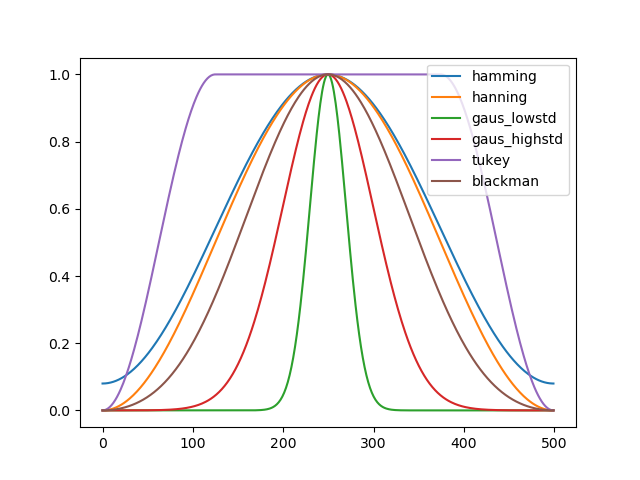

In [10]:
plt.figure()
for name, window in window_types.items():
    plt.plot(window, label=name)
plt.legend()

In [11]:
wintype_pwvds = {}
for name, win_type in tqdm(window_types.items()):
    p = PseudoWignerVilleDistribution(analytical, fwindow=win_type);
    pwvd, t, f = p.run();
    wintype_pwvds[name] = pwvd

100%|████████████████████████████████████████████| 6/6 [00:31<00:00,  5.23s/it]


<IPython.core.display.Javascript object>


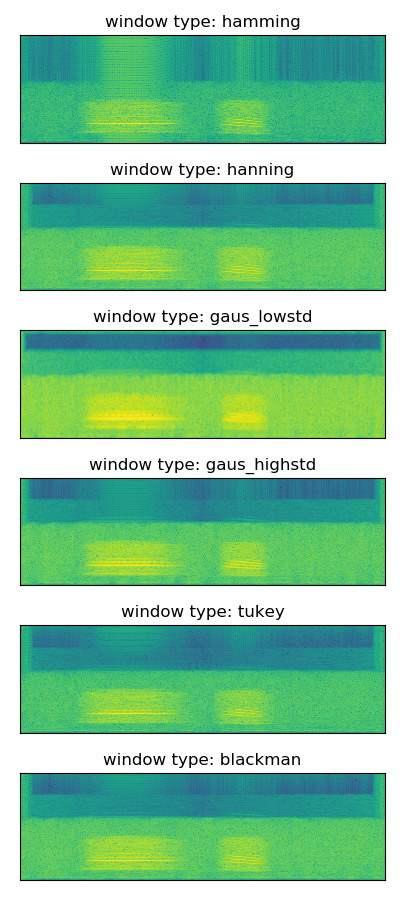

c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\signal_processing.py:13: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(X)


In [12]:
plt.figure(figsize=(4,9))
for i, (name, pwvd) in enumerate(wintype_pwvds.items()):
    plt.subplot(len(window_types)*100+11+i)
    plt.imshow(dB(abs(pwvd)), origin='lower', aspect='auto')
    plt.title('window type: %s'%name)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

<IPython.core.display.Javascript object>


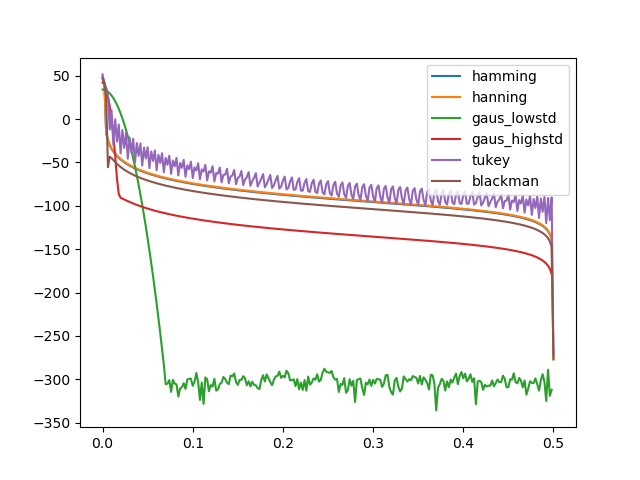

c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\signal_processing.py:13: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(X)
c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\signal_processing.py:13: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(X)


In [13]:
plt.figure()
for name, wintype in window_types.items():
    power_spectrum, f = get_power_spectrum(wintype, 1.0)
    plt.plot(f, power_spectrum, label=name)
plt.legend()

<IPython.core.display.Javascript object>


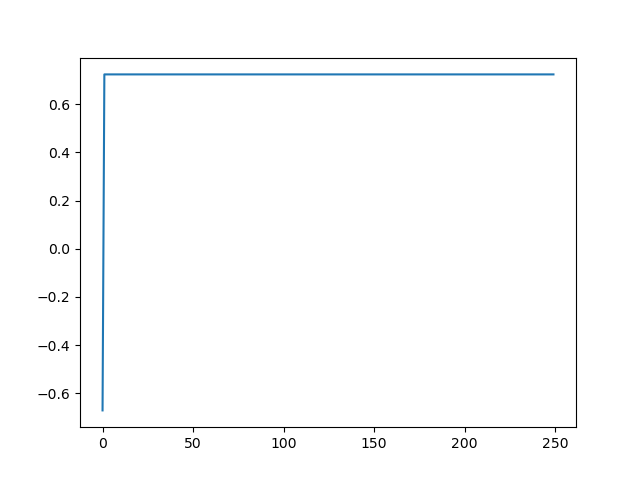

c:\users\tbeleyur\google drive\holger goerlitz- imprs\phd_2015\projects and analyses\packages\measure_horseshoe_bat_calls\measure_horseshoe_bat_calls\signal_processing.py:13: RuntimeWarning: divide by zero encountered in log10
  return 20*np.log10(X)


In [14]:
# there are some differences between hamming and hanning:
plt.figure()
hamming_ps, f = get_power_spectrum(window_types['hamming'], 1.0)
hanning_ps, f = get_power_spectrum(window_types['hanning'], 1.0)
plt.plot(hanning_ps-hamming_ps)
# nope, apparently not!

### Some basic lessons
The PWVD behaves like the spectrogram in that a longer window has a somewhat less faithful representation of the frequency change in the sound, *and* can introduce more 'interference' terms. A shorter window is better, though it provides lower frequency resolution. The window used has a *big* difference in the outcome of the PWVD. A lowpass filter 'narrow' gaussian filter essentially has a very low frequency resolution, leading to blurry time-frequency representation. 

Essentially, now I'm thinking the nicest combination is a 1ms Hanning window!

<IPython.core.display.Javascript object>


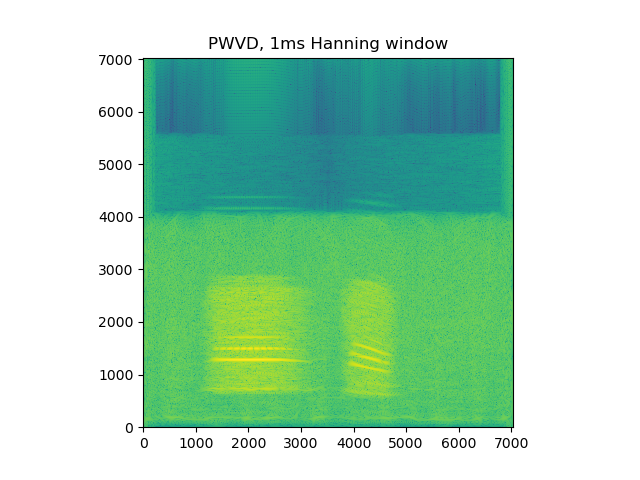

Text(0.5, 1.0, 'PWVD, 1ms Hanning window')

In [15]:
plt.figure()
plt.imshow(dB(abs(wintype_pwvds['hanning'])), origin='lower',)
plt.title('PWVD, 1ms Hanning window')

In [16]:
import datetime as dt
print('This notebook run last at : %s'%dt.datetime.now())

# -- Thejasvi Beleyur, April 2020, run on Win7 laptop

This notebook run last at : 2020-04-13 18:43:41.952661
